# Investigating the behaviour of vacuum energy density in finite dimensional Hilbert spaces
## Table of contents:

- Section 1: error function approximation to the results of Singh & Carroll (2018)
- Section 2: Dynamical vacuum energy from Hilbert space finite dimensionality

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import mpmath

In [2]:
# Defining a number of constants
L_Planck_in_SI = 1.616255e-35
E_Planck_in_SI = 1.956e9
E_Planck_in_eV = 1.2209e28
R_hubble_prefactor = 2.9979*3.0857*1.0e25/L_Planck_in_SI
kUV = 1.0
h = 0.7
R_Hubble_in_Planck = R_hubble_prefactor/h
L_c = 4.4963302789e+00*R_Hubble_in_Planck # particle horizon at a->infty for (Omega_m = 0.286, h = 0.7)

# floating point precition of mpmath module
mpmath.mp.dps = 25

# Section 1: error function approximation to the results of Singh & Carroll (2018)

In [13]:
# Please note: This does not yet conform to the new notation of our draft, i.e. it does not include our resolution criterion.

In [3]:
def csc(theta):
    return 1.0/np.sin(theta)

# This function returns the Hamiltonian of a finite dimensional harmonic oscillator,
# as derived in Singh & Carroll (2018), https://arxiv.org/pdf/1806.10134.pdf
#
def return_Hamiltonian(Omega, l_max):
    N = 2*l_max + 1
    H = np.zeros((N,N))
    #
    # pre-calculating factors to simplify the subsequent computations:
    prefactor_1 = 2.0*np.pi*l_max/(2.0*l_max+1)
    prefactor_2 = 0.25*np.pi/(2.0*l_max+1)
    prefactor_3 = Omega**2*np.pi/(2.0*l_max+1)
    #
    # The indices of the Hamitonian matrix range from -l to l
    # (cf. Singh & Carroll)
    x = np.arange(-l_max,l_max+0.5, 1.0).astype('int')
    y1 = 0.0*x
    y2 = 0.0*x
    #
    # calculating the term in the Hamiltonian that is proportional
    # to the position operator:
    for j in range(-l_max,l_max+1):
        H[j+l_max,j+l_max] = prefactor_3*j**2
    #
    # calculating the term in the Hamiltonian that is proportional
    # to the momentum operator:
    for j1 in range(-l_max,l_max+1):
        indxs = np.where(x != j1)[0]
        y1[indxs] = csc(prefactor_1*(j1-x[indxs]))
        y1[j1+l_max] = 0.0
        for j2 in range(j1,l_max+1):
            indxs = np.where(x != j2)[0]
            y2[indxs] = csc(prefactor_1*(j2-x[indxs]))
            y2[j2+l_max] = 0.0
            H[j1+l_max,j2+l_max] += np.sum(y1*y2)*prefactor_2
    H += np.transpose(H)
    for j in range(-l_max,l_max+1):
        H[j,j] /= 2.0
    return H

# Computing the minimum eigenvalue of the Hamiltonian
#
def return_lambda_min(Omega, l_max):
    H = np.matrix(return_Hamiltonian(Omega, l_max))
    evs = scipy.linalg.eigh(H)[0]
    return np.min(evs)

# Error function approximation to the minimum eigenvalue
#
def return_lambda_min_approximate(Omega, l_max):
    return 0.5*Omega*scipy.special.erf((l_max+0.5)*np.pi**1.5/(6.0*Omega))

In [4]:
N_max = 121
Omega = 30.0
lambda_min_values = np.zeros(int((N_max-1)/2))
lambda_min_approximate_values = np.zeros(int((N_max-1)/2))
ii = 0
for j in range(1,N_max,2):
    l_max = int((j-1)/2+0.5)
    lambda_min_values[ii] = return_lambda_min(Omega, l_max)
    lambda_min_approximate_values[ii] = return_lambda_min_approximate(Omega, l_max)
    ii += 1

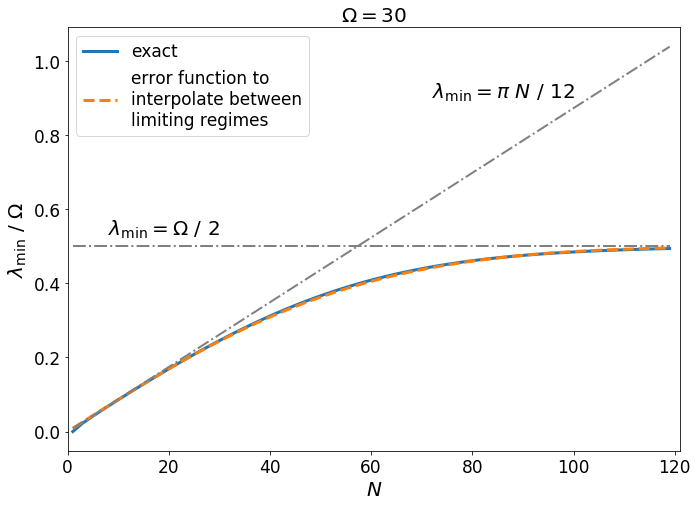

In [5]:
plt.figure(figsize=(10,7))
x_values = np.arange(1,N_max,2)
plt.plot(x_values, lambda_min_values/Omega, linestyle='solid', color='tab:blue', linewidth=3, label='exact')
plt.plot(x_values, lambda_min_approximate_values/Omega, linestyle='dashed', color='tab:orange', linewidth=3, label='error function to\ninterpolate between\nlimiting regimes')
#
plt.plot(x_values, np.pi*x_values/12.0/Omega, linestyle='-.', color='grey', linewidth=2)
plt.plot(x_values, x_values*0.0+0.5, color='grey', linestyle='-.', linewidth=2)
plt.xlim(0,N_max)
#plt.ylim(0,0.6)

plt.text(72,0.9,r"$\lambda_{\mathrm{min}} = \pi\ N\ /\ 12$", size=20)
plt.text(8,0.53,r"$\lambda_{\mathrm{min}} = \Omega\ /\ 2$", size=20)

plt.legend(fontsize=17)
plt.xticks(size=17)
plt.yticks(size=17)
plt.xlabel(r"$N$", size=20)
plt.ylabel(r"$\lambda_{\min}\ /\ \Omega$", size=20)
plt.title(r"$\Omega = 30$", size=20)
plt.subplots_adjust(left=0.1, bottom=0.1, top=0.94, right=0.95)
plt.savefig("approx_to_lambda_min.pdf")


# Section 2: Dynamical vacuum energy from Hilbert space finite dimensionality

In [6]:

# This uses brute force trapezoidal quadrature, because mpmath does not interface with numpy integration
# routines. (But we have to use mpmath, because numpy can't handle the vast dynamic range of numbers
# required for the calculations.)
#
# This is integrating equation 3.2 of the draft (and derivatives thereof)
#
def return_vacuum_energy_density_and_derivatives(R_Hubble_in_Planck, kUV, D, n_D):
    A = mpmath.pi**1.5/12.0/kUV**2
    X = 1.0/(2.0*np.pi)**2
    Y = n_D/R_Hubble_in_Planck*2.0/np.sqrt(np.pi)/(2.0*np.pi)**2
    dmin = 2.0
    N_k = 5000
    k_min = 1.0/R_Hubble_in_Planck
    logk_min = mpmath.log(k_min)
    k_max = kUV
    logk_max = mpmath.log(k_max)
    dlogk = (logk_max - logk_min)/(N_k-1)
    logk_values = np.arange(float(logk_min), float(logk_max+0.5*dlogk), float(dlogk))
    integrand_eps = []
    integrand_deps_dR = []
    integrand_d2eps_dR2 = []
    result = 0.0
    for i in range(0, len(logk_values)):
        k = mpmath.exp(logk_values[i])
        Ak = A*k**2
        Ck = Ak*dmin
        Ak = Ak*D*(k*R_Hubble_in_Planck)**n_D
        Ck = Ck + Ak
        k4 = k**4
        k4Ak_exp = k4*Ak*mpmath.exp(-Ck**2)
        integrand_eps.append(k4*mpmath.erf(Ck))
        integrand_deps_dR.append(k4Ak_exp)
        integrand_d2eps_dR2.append(k4Ak_exp*(1.0-2.0*Ck*Ak))
    #
    integrand_eps = np.array(integrand_eps)
    integrand_eps *= X
    #
    integrand_deps_dR = np.array(integrand_deps_dR)
    integrand_deps_dR *= Y
    #
    integrand_d2eps_dR2 = np.array(integrand_d2eps_dR2)
    integrand_d2eps_dR2 *= n_D*Y
    integrand_d2eps_dR2 -= integrand_deps_dR
    integrand_d2eps_dR2 /= R_Hubble_in_Planck
    #
    return np.sum(integrand_eps[:-1]+integrand_eps[1:])*0.5*dlogk, np.sum(integrand_deps_dR[:-1]+integrand_deps_dR[1:])*0.5*dlogk, np.sum(integrand_d2eps_dR2[:-1]+integrand_d2eps_dR2[1:])*0.5*dlogk

# This uses equations 3.3 and 3.10 of the draft to calculate the
# equation of state parameters of vacuum energy density:
#
def return_w(R_Hubble_in_Planck, kUV, D, n_D):
    eps, deps_dR, d2eps_dR2 = return_vacuum_energy_density_and_derivatives(R_Hubble_in_Planck, kUV, D, n_D)
    w0 = -(1.0+deps_dR*R_Hubble_in_Planck/eps/3.0)
    wa = R_Hubble_in_Planck/(3.0*eps)*(deps_dR - R_Hubble_in_Planck*deps_dR**2/eps + R_Hubble_in_Planck*d2eps_dR2)
    return eps, w0, wa


In [7]:
# Calculating w_0 and w_a on a grid of the parameters n_D and Y (defined in equations
# 2.36 and 3.4 of the draft).
#

N_param = 20
D_min = 1.0e10
logD_min = np.log(D_min)
D_max = 1.0e90
logD_max = np.log(D_max)
dlogD = (logD_max-logD_min)/(N_param-1)

n_min = 0.0
n_max = -3.0
dn = (n_max-n_min)/(N_param-1)

def lnD_from_y_and_n_D(y, n_D):
    lnD = y - n_D*np.log(kUV*L_c)
    return lnD

dmin = 2.0
y_min = np.log(dmin*1.0e-2)
y_max = np.log(dmin*1.0e1)
dy = (y_max-y_min)/(N_param-1)

n_values = np.arange(n_min, n_max + 0.5*dn, dn)
y_values = np.arange(y_min, y_max + 0.5*dy, dy)
w_values = np.zeros((N_param, N_param))
wa_values = np.zeros((N_param, N_param))

for j in range(0, N_param):
    n_D = x=n_values[j]
    for i in range(0, N_param):
        y = y_values[i]
        lnD = lnD_from_y_and_n_D(y, n_D)
        print(j,i, mpmath.exp(lnD), n_D)
        x, w_values[i,j], wa_values[i,j] = return_w(L_c, kUV, mpmath.exp(lnD), n_D)

0 0 0.02000000000000000195539599 0.0
0 1 0.02876899776575325901738936 0.0
0 2 0.04138276162229579641406814 0.0
0 3 0.05952702883262636815813883 0.0
0 4 0.08562664797438788242170658 0.0
0 5 0.1231696422132052785251634 0.0
0 6 0.1771733580820165304299136 0.0
0 7 0.2548549971406267590952617 0.0
0 8 0.3665961421664871865496534 0.0
0 9 0.5273301797460716473217928 0.0
0 10 0.7585380381464499109561786 0.0
0 11 1.091118956233703785733988 0.0
0 12 1.569519940702922457662383 0.0
0 13 2.257675783369377967355707 0.0
0 14 3.247553478377443360210405 0.0
0 15 4.671442938180244183191422 0.0
0 16 6.7196365725675635725621 0.0
0 17 9.665860477143505233590777 0.0
0 18 13.90385592355121025135653 0.0
0 19 19.99999999999999721636494 0.0
1 0 105168568.5923183963958193 -0.15789473684210525
1 1 151279715.7429938009453028 -0.15789473684210525
1 2 217608290.2106988179162701 -0.15789473684210525
1 3 313018620.7440490233252925 -0.15789473684210525
1 4 450261600.0412356103671142 -0.15789473684210525
1 5 647678748.27

7 18 1.545706487886286378359566e+69 -1.1052631578947367
7 19 2.223421324825544269787237e+69 -1.1052631578947367
8 0 1.1691701905477024609322e+76 -1.263157894736842
8 1 1.681792729982608046238279e+76 -1.263157894736842
8 2 2.419174564566486008994755e+76 -1.263157894736842
8 3 3.47986138214901712187828e+76 -1.263157894736842
8 4 5.00560621640880558268447e+76 -1.263157894736842
8 5 7.200313702805276903755735e+76 -1.263157894736842
8 6 1.035729044143637832232105e+77 -1.263157894736842
8 7 1.489844327844703623164625e+77 -1.263157894736842
8 8 2.143066406954222014291123e+77 -1.263157894736842
8 9 3.082693633676343582723542e+77 -1.263157894736842
8 10 4.434300312986825768567406e+77 -1.263157894736842
8 11 6.378518789849847761719992e+77 -1.263157894736842
8 12 9.175179640700271689872257e+77 -1.263157894736842
8 13 1.319803612918454401369828e+78 -1.263157894736842
8 14 1.89847135956420450303068e+78 -1.263157894736842
8 15 2.730855915082457302631752e+78 -1.263157894736842
8 16 3.9281993859800639

15 4 5.564785802621366067298535e+144 -2.3684210526315788
15 5 8.004665516125248541959233e+144 -2.3684210526315788
15 6 1.151431021745079779287258e+145 -2.3684210526315788
15 7 1.656275824600112382380678e+145 -2.3684210526315788
15 8 2.382469774869655973311206e+145 -2.3684210526315788
15 9 3.427063381509892397141429e+145 -2.3684210526315788
15 10 4.929658938287784782064143e+145 -2.3684210526315788
15 11 7.091067349076140934948205e+145 -2.3684210526315788
15 12 1.020014503611915809809007e+146 -2.3684210526315788
15 13 1.467239748772314429210315e+146 -2.3684210526315788
15 14 2.110550852712814123078122e+146 -2.3684210526315788
15 15 3.035921638310092674853877e+146 -2.3684210526315788
15 16 4.367021141477375185741109e+146 -2.3684210526315788
15 17 6.28174107310781352654595e+146 -2.3684210526315788
15 18 9.035969744864214287134601e+146 -2.3684210526315788
15 19 1.299778967007026064711911e+147 -2.3684210526315788
16 0 6.834794672326999592322866e+153 -2.526315789473684
16 1 9.8315096328776060

8.190679007289705e-16
0.33333333333333337 -0.11111111111076041


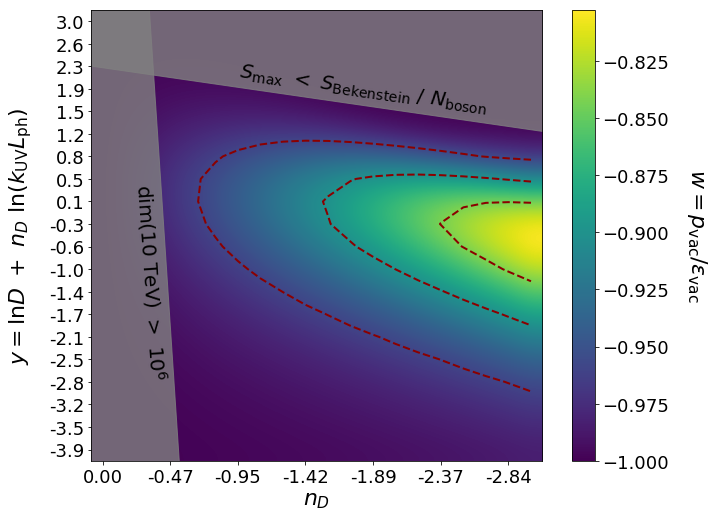

In [8]:
plt.figure(figsize=(10,7.2))

plt.imshow(w_values, interpolation='bicubic')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'$w = p_{\mathrm{vac}}/\epsilon_{\mathrm{vac}}$', size=22, rotation=270, labelpad=40)
plt.clim(-1.0,np.max(w_values))
cons = plt.contour(w_values, colors='darkred', linewidths=2, levels=[-0.96, -0.9, -0.84])


ax = plt.gca()
ax.set_ylim(N_param-0.5, -0.5)
ax.set_xlim(-0.5, N_param-0.5)
xx = np.arange(-0.5, N_param-0.4, 0.1)
nn = n_min + xx/N_param*(n_max - n_min)
kLHC = 1.0e13/E_Planck_in_eV
print(kLHC)
yy = np.log(1.0e6-2) - nn*np.log(kLHC/kUV)
yy = (yy-y_min)/(y_max-y_min)*float(N_param) - 0.5
ax.fill_between(xx, 0.0*yy-1.0, yy, color="grey", alpha = 0.8)

def integrand_1(x):
    return x**2

def integrand_2(x):
    return x**2*np.log(x)

A = scipy.integrate.quad(integrand_1, 1.0/L_c, kUV)[0]
B = scipy.integrate.quad(integrand_2, 1.0/L_c, kUV)[0]
print(A,B)

def return_y_max(kUV, n_D, L_ph):
    # y == lnD + n_D*ln(kUV*R_Hubble_in_Planck)
    N_boson = 1.0 + 2.0*1 + 3.0*3 + 2.0*8
    return 6.0*np.pi**2/kUV**3/N_boson + n_D*(np.log(kUV) - B/A)

yy = return_y_max(kUV, nn, L_c)
yy = (yy-y_min)/(y_max-y_min)*float(N_param) - 0.5
ax.fill_between(xx, yy, 0.0*yy+N_param, color="grey", alpha = 0.8)

ax.invert_yaxis()
indxs = np.arange(0, N_param-0.5, 3).astype("int")
ax.set_xticks(np.arange(0., N_param - 0.1, 3), minor=False)
ax.set_yticks(np.arange(0., N_param - 0.1, 1), minor=False)
y_strings = ["%.1f" % x for x in y_values]
x_strings = ["%.2f" % x for x in n_values[indxs]]
ax.set_xticklabels(x_strings, size=18)
ax.set_yticklabels(y_strings, size=18)

plt.ylabel(r'$y = \ln D\ +\ n_D\ \ln(k_{\mathrm{UV}}L_{\mathrm{ph}})$', size=22, labelpad = 15)
plt.xlabel(r'$n_D$', size=22)

plt.text(6.0, 16.5, r"$S_{\max}\ <\ S_{\mathrm{Bekenstein}}\ /\ N_{\mathrm{boson}}$", size=20, rotation=-8)
plt.text(1.3, 11, r"$\mathrm{dim}(10\ \mathrm{TeV})\ >\ 10^6$", size=20, rotation=-86)

plt.subplots_adjust(left = 0.10, bottom=0.10, top=0.97, right=0.93)
plt.savefig("w_as_function_of_dimensionality.pdf")

In [9]:
print(mpmath.erf(np.pi**1.5/6))

0.8106375536407908696697574


0.33333333333333337 -0.11111111111076041


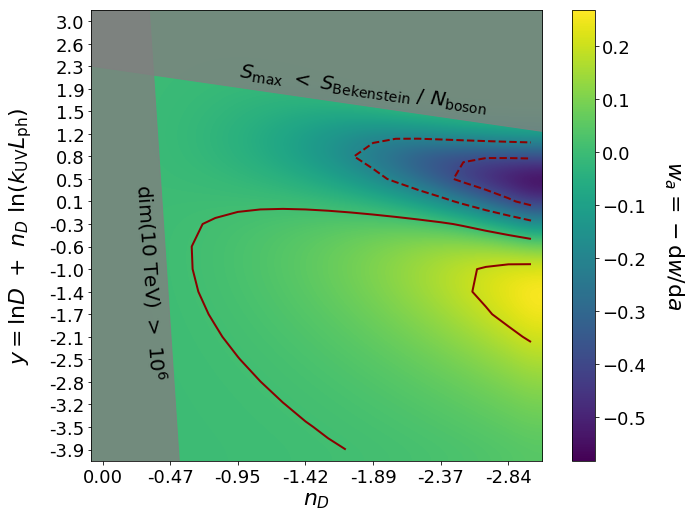

In [10]:
plt.figure(figsize=(10,7.2))

plt.imshow(wa_values, interpolation='bicubic')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'$w_a = -\mathrm{d}w/\mathrm{d}a$', size=22, rotation=270, labelpad=40)
#plt.clim(-1.0,np.max(w_values))
cons = plt.contour(wa_values, colors='darkred', linewidths=2, levels=[-0.4, -0.2, 0.01, 0.2])


ax = plt.gca()
ax.set_ylim(N_param-0.5, -0.5)
ax.set_xlim(-0.5, N_param-0.5)
xx = np.arange(-0.5, N_param-0.4, 0.1)
nn = n_min + xx/N_param*(n_max - n_min)
kLHC = 1.0e13/E_Planck_in_eV
yy = np.log(1.0e6-2) - nn*np.log(kLHC/kUV)
yy = (yy-y_min)/(y_max-y_min)*float(N_param) - 0.5
ax.fill_between(xx, 0.0*yy-1.0, yy, color="grey", alpha = 0.8)

def integrand_1(x):
    return x**2

def integrand_2(x):
    return x**2*np.log(x)

A = scipy.integrate.quad(integrand_1, 1.0/L_c, kUV)[0]
B = scipy.integrate.quad(integrand_2, 1.0/L_c, kUV)[0]
print(A,B)

def return_y_max(kUV, n_D, L_ph):
    # y == lnD + n_D*ln(kUV*L_c)
    N_boson = 1.0 + 2.0*1 + 3.0*3 + 2.0*8
    return 6.0*np.pi**2/kUV**3/N_boson + n_D*(np.log(kUV) - B/A)

yy = return_y_max(kUV, nn, L_c)
yy = (yy-y_min)/(y_max-y_min)*float(N_param) - 0.5
ax.fill_between(xx, yy, 0.0*yy+N_param, color="grey", alpha = 0.8)

ax.invert_yaxis()
indxs = np.arange(0, N_param-0.5, 3).astype("int")
ax.set_xticks(np.arange(0., N_param - 0.1, 3), minor=False)
ax.set_yticks(np.arange(0., N_param - 0.1, 1), minor=False)
y_strings = ["%.1f" % x for x in y_values]
x_strings = ["%.2f" % x for x in n_values[indxs]]
ax.set_xticklabels(x_strings, size=18)
ax.set_yticklabels(y_strings, size=18)

plt.text(6.0, 16.5, r"$S_{\max}\ <\ S_{\mathrm{Bekenstein}}\ /\ N_{\mathrm{boson}}$", size=20, rotation=-8)
plt.text(1.3, 11, r"$\mathrm{dim}(10\ \mathrm{TeV})\ >\ 10^6$", size=20, rotation=-86)

plt.ylabel(r'$y = \ln D\ +\ n_D\ \ln(k_{\mathrm{UV}}L_{\mathrm{ph}})$', size=22, labelpad = 15)
plt.xlabel(r'$n_D$', size=22)


plt.subplots_adjust(left = 0.10, bottom=0.10, top=0.97, right=0.93)
plt.savefig("wa_as_function_of_dimensionality.pdf")

In [11]:
Lph_max = 2.0*L_c
Lph_min = 0.25*L_c
N = 50
dL = (Lph_max-Lph_min)/float(N-1)
L_values = np.arange(Lph_min , Lph_max + 0.5*dL, dL)
w_vals_1 = np.zeros(N)
w_vals_2 = np.zeros(N)
w_vals_3 = np.zeros(N)
eps_vals_1 = np.zeros(N)
eps_vals_2 = np.zeros(N)
eps_vals_3 = np.zeros(N)

n_D = -3.0
y = -0.5
D = mpmath.exp(y-n_D*np.log(kUV*L_c))
for i in range(0,N):
    print(i)
    eps_vals_1[i], w_vals_1[i], x = return_w(L_values[i], kUV, D, n_D)
    
n_D = -2.0
y = -0.5
D = mpmath.exp(y-n_D*np.log(kUV*L_c))
for i in range(0,N):
    print(i)
    eps_vals_2[i], w_vals_2[i], x = return_w(L_values[i], kUV, D, n_D)
    
n_D = -3.0
y = -1.0
D = mpmath.exp(y-n_D*np.log(kUV*L_c))
for i in range(0,N):
    print(i)
    eps_vals_3[i], w_vals_3[i], x = return_w(L_values[i], kUV, D, n_D)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


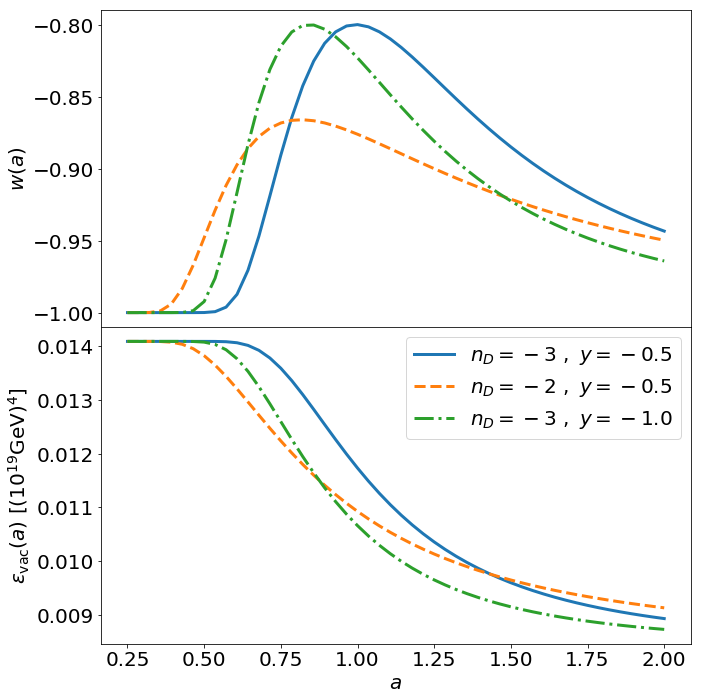

In [12]:

fig, axes = plt.subplots(nrows=2,  sharex=True, figsize=(10,10))
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

Lph = R_hubble_prefactor/h

axes[1].plot(L_values/L_c, eps_vals_1*(E_Planck_in_eV*1.0e-9)**4/1.0e76, linewidth=3, linestyle='solid', label=r'$n_D = -3\ ,\ y = -0.5$')
axes[1].plot(L_values/L_c, eps_vals_2*(E_Planck_in_eV*1.0e-9)**4/1.0e76, linewidth=3, linestyle='dashed', label=r'$n_D = -2\ ,\ y = -0.5$')
axes[1].plot(L_values/L_c, eps_vals_3*(E_Planck_in_eV*1.0e-9)**4/1.0e76, linewidth=3, linestyle='-.', label=r'$n_D = -3\ ,\ y = -1.0$')
axes[1].set_xlabel(r"$a$", size=20)
axes[1].set_ylabel(r"$\epsilon_{\mathrm{vac}}(a)$ [$(10^{19}$GeV$)^4$]", size=20)
axes[1].legend(fontsize=20)

axes[0].plot(L_values/L_c, w_vals_1, linewidth=3, linestyle='solid', label=r'$n_D = -3\ ,\ y = -0.5$')
axes[0].plot(L_values/L_c, w_vals_2, linewidth=3, linestyle='dashed', label=r'$n_D = -2\ ,\ y = -0.5$')
axes[0].plot(L_values/L_c, w_vals_3, linewidth=3, linestyle='-.', label=r'$n_D = -3\ ,\ y = -1.0$')
axes[0].set_xlabel(r"$a$", size=20)
axes[0].set_ylabel(r"$w(a)$", size=20)
#axes[0].legend(fontsize=20)


plt.subplots_adjust(left=0.16, bottom=0.09, top=0.97, right=0.98, hspace=0.0)
plt.savefig("eps_vs_a.pdf")